In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Importing standard Qiskit modules
from qiskit import QuantumCircuit, QuantumRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter, ParameterVector

# Import state tomography modules
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity

In [3]:
provider = IBMQ.load_account()

In [5]:
provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
jakarta = provider.get_backend('ibmq_jakarta')

# properties = jakarta.properties()

# Simulated backend based on ibmq_jakarta's device noise profile
sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))

# Noiseless simulated backend
sim = QasmSimulator()


## Make the compressed XYZ gate a variational gate

In [6]:
def R_xyz(t):
    
    t_qr = QuantumRegister(2)
    t_qc = QuantumCircuit(t_qr, name='XYZ')
    
    t_qc.cnot(0,1)
    t_qc.rx(2*t-np.pi/2, 0)
    t_qc.rz(2 * t, 1)
    t_qc.h(0)
    t_qc.cnot(0,1)
    t_qc.h(0)
    t_qc.rz(-2 * t, 1)
    t_qc.cnot(0,1)
    t_qc.rx(np.pi/2,0)
    t_qc.rx(-np.pi/2,1)

    return t_qc

In [138]:
def R_xyz_variational(theta, trotter_step, i):
    
    t_qr = QuantumRegister(2)
    t_qc = QuantumCircuit(t_qr, name='XYZ')
    
    t_qc.cnot(0,1)

    print(trotter_step*3 )
    
    t_qc.rx(2*theta[3*(trotter_step+i)+3*trotter_step]-np.pi/2, 0)
    t_qc.rz(2 * theta[3*(trotter_step+i) + 1 + 3*trotter_step], 1)
    t_qc.h(0)
    t_qc.cnot(0,1)
    t_qc.h(0)
    t_qc.rz(-2 * theta[3*(trotter_step+i) + 2 + 3*trotter_step], 1)
    t_qc.cnot(0,1)
    t_qc.rx(np.pi/2,0)
    t_qc.rx(-np.pi/2,1)

    return t_qc

In [139]:
# Parameterize variable t to be evaluated at t=pi later
t = Parameter('t')

In [140]:
theta = ParameterVector('theta', 3*2*4)

In [141]:
num_qubits = 3

Trot_qr = QuantumRegister(num_qubits)
Trot_qc = QuantumCircuit(Trot_qr, name='Trot')

### Alternative 1

# Get the simple stuff to work first!

for trotter_step in range(0, 4):
    for i in range(0, num_qubits - 1):
        Trot_qc.append(R_xyz_variational(theta, trotter_step, i).to_instruction(), [Trot_qr[i], Trot_qr[i+1]])

### Alternative 2

# Trot_qc.append(R_xyz(2*t).to_instruction(), [Trot_qr[0], Trot_qr[1]])
# Trot_qc.append(R_xyz(t).to_instruction(), [Trot_qr[1], Trot_qr[2]])
# Trot_qc.append(R_xyz(3*t).to_instruction(), [Trot_qr[0], Trot_qr[1]])
# Trot_qc.append(R_xyz(t).to_instruction(), [Trot_qr[1], Trot_qr[2]])
# Trot_qc.append(R_xyz(t).to_instruction(), [Trot_qr[0], Trot_qr[1]])

# Convert custom quantum circuit into a gate
Trot_gate = Trot_qc.to_instruction()

0
0
3
3
6
6
9
9


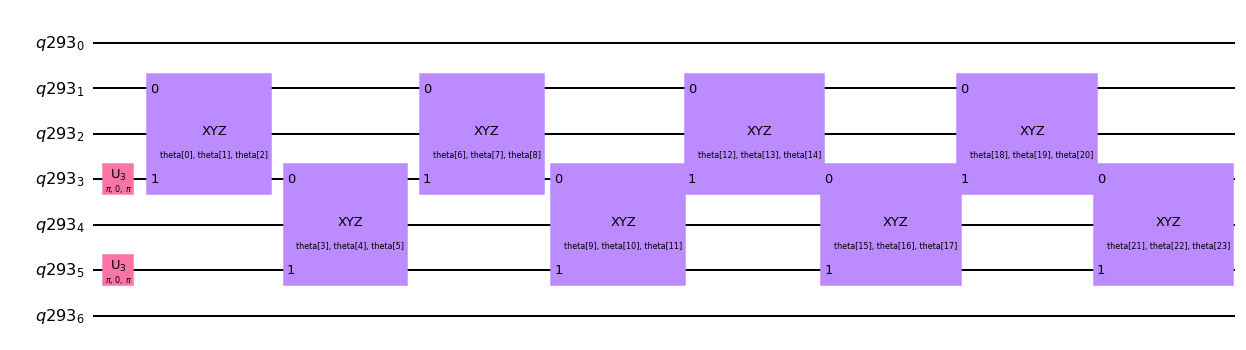

In [142]:
# The final time of the state evolution
# target_time = np.pi

# Number of trotter steps
trotter_steps = 4  ### CAN BE >= 4

# Initialize quantum circuit for 3 qubits
qr = QuantumRegister(7)
qc = QuantumCircuit(qr)

# Prepare initial state (remember we are only evolving 3 of the 7 qubits on jakarta qubits (q_5, q_3, q_1) corresponding to the state |110>)
qc.x([3,5])  # DO NOT MODIFY (|q_5,q_3,q_1> = |110>)

# Simulate time evolution under H_heis3 Hamiltonian
## Standard and alternative 1

#for _ in range(trotter_steps):
#    qc.append(Trot_gate, [qr[1], qr[3], qr[5]])
    
## Alternative 2
qc.append(Trot_gate, [qr[1], qr[3], qr[5]])

# Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
#qc = qc.bind_parameters({t: target_time/trotter_steps})

qc.decompose().draw(output="mpl")  # view decomposition of trotter gates

In [67]:
# TBD: The variational parameters need to be optimized